## Imports

In [262]:
import torch
from torch import nn
from torch.nn import functional as F
import time
from math import sqrt

import matplotlib.pyplot as plt

import dlc_practical_prologue

## Useful functions

In [263]:
def mean(x):
    return sum(x)/len(x)

def var(x):
    u = mean(x)
    return sum([(v-u)**2 for v in x])/len(x)

In [264]:
def number_parameters(model):   # Returns the number of parameter of a given model
    return sum(p.numel() for p in model.parameters())

## Load data

In [265]:
N = 1000

x_train, y_train, y_train_classes, x_test, y_test, y_test_classes = \
dlc_practical_prologue.generate_pair_sets(N)

assert x_train.shape == torch.Size([N, 2, 14, 14])    # float32
assert y_train.shape == torch.Size([N])               # int64
assert y_train_classes.shape == torch.Size([N, 2])    # int64

assert x_test.shape == torch.Size([N, 2, 14, 14])
assert y_test.shape == torch.Size([N])
assert y_test_classes.shape == torch.Size([N, 2])

In [266]:
if torch.cuda.is_available():  
    dev = "cuda:0"
else:  
    dev = "cpu"  
device = torch.device(dev)

## Normalize input

In [267]:
# Normalizing using ONLY x_train data

x_list = torch.flatten(x_train).tolist()

m = mean(x_list)
v = var(x_list)
x_train = x_train.sub(m).div(sqrt(v))
x_test = x_test.sub(m).div(sqrt(v))

## -----------------------------------------------------------------------------------------------

## Define models 

# Model 0
Is a naive MLP

In [268]:
## Is a naive Multi Layer Perceptron, composed of fully connected linear layers.

class model_0(nn.Module):   
    def __init__(self, ns = [392,256,64,2]):
        super().__init__()
        layers = [nn.Linear(n_in, n_out) for n_in, n_out in zip(ns[:-1], ns[1:])]   
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = torch.flatten(x,1)          # flatten the 2 images in one vector (but keeping batch size)
        for layer in self.layers[:-1]:
            x = layer(x).relu()
            
        x = self.layers[-1](x) 
        return x

model_test = model_0()
model_test(x_train[0:2])    
print(number_parameters(model_0()))

117186


# MODEL 1

Is a simple CNN of **2 Conv Layers** -- 
4 versions of it are implemented:
 * straightforward CNN (model_1)
 * **Finally, I think this one is to simple to justify an intermediate loss without digit prediction** -> Not present
 * with the two images composing the input treated identically and independently (model_1_ws)
 * with the two images composing the input treated identically and independently + Digit predictions for aux loss (model_1_ws_aux2)

In [342]:
## Is a convolutional neural network of small depth 

class model_1(nn.Module):                 
    def __init__(self):
        super(model_1, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=2, padding=1)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)

        self.dense1 = nn.Linear(1152, 16)
        self.dense2 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.leaky_relu(self.conv2(x))
        
        x = torch.flatten(x, 1)
        
        x = F.leaky_relu(self.dense1(x))
        x = self.dense2(x)
        return x

model_test = model_1()
model_test(x_train[0:2])
print(number_parameters(model_test))

20706


In [377]:
class model_1_ws(nn.Module):                 
    def __init__(self):
        super(model_1_ws, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, padding=1)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)

        self.dense1 = nn.Linear(2304, 10)
        self.dense2 = nn.Linear(10, 2)
        
    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.max_pool2d(d1, kernel_size=2) 
        d1 = F.leaky_relu(self.conv2(d1))
        d1 = torch.flatten(d1, 1)
#         d1 = F.leaky_relu(self.dense1(d1))
#         d1 = self.dense_digits(d1)
        
        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.max_pool2d(d2, kernel_size=2) 
        d2 = F.leaky_relu(self.conv2(d2))
        d2 = torch.flatten(d2, 1)
#         d2 = F.leaky_relu(self.dense1(d2))
#         d2 = self.dense_digits(d2)
        
        x = F.leaky_relu(torch.cat((d1, d2), 1))
        x = torch.flatten(x, 1)
        
        x = F.leaky_relu(self.dense1(x))
        x = self.dense2(x)
        
        return x

model_test = model_1_ws()
model_test(x_train[0:2])
print(number_parameters(model_test))

25232


In [352]:
## Is a convolutional neural network poorly paramztrized    

class model_1_ws_aux2(nn.Module):                 
    def __init__(self):
        super(model_1_ws_aux2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, padding=1)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)

        self.dense1 = nn.Linear(1152, 16)
        self.dense_digits = nn.Linear(16, 10)
        self.dense2 = nn.Linear(20, 2)
        
    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.max_pool2d(d1, kernel_size=2) 
        d1 = F.leaky_relu(self.conv2(d1))
        d1 = torch.flatten(d1, 1)
        d1 = F.leaky_relu(self.dense1(d1))
        d1 = self.dense_digits(d1)                    # digit prediction of the first image
        
        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.max_pool2d(d2, kernel_size=2) 
        d2 = F.leaky_relu(self.conv2(d2))
        d2 = torch.flatten(d2, 1)
        d2 = F.leaky_relu(self.dense1(d2))
        d2 = self.dense_digits(d2)                    # digit prediction of the second image
        
        x = F.leaky_relu(torch.cat((torch.softmax(d1, -1), torch.softmax(d2, -1)), 1))
        x = torch.flatten(x, 1)
        
        x = F.leaky_relu(self.dense2(x))
        
        return x,d1,d2

    
model_test = model_1_ws_aux2()
model_test(x_train[0:2])
print(number_parameters(model_test))

20820


# MODEL 2

Is a more complex CNN, of **3 conv Layers** -- 
4 versions of it are implemented:
 * straightforward CNN (model_2)
 * !!NOT WORKING!! with intermediate output for auxiliary loss (model_2_aux1)
 * with the two images composing the input treated identically and independently (model_2_ws)
 * with the two images composing the input treated identically and independently + Digit predictions for aux loss (model_2_ws_aux2) **currently our best model**

In [278]:
class model_2(nn.Module):
    def __init__(self):
        super(model_2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) # NEW size
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        
        self.dense1 = nn.Linear(4608, 64)
        self.dense2 = nn.Linear(64, 12)
        self.dense3 = nn.Linear(12, 2) 

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.dense1(x))
        x = self.dense2(x)
        x = F.dropout(x)
        x = self.dense3(x)

        return x

model_test = model_2()
model_test(x_train[0:2])
print(number_parameters(model_test))

337222


In [279]:
# Early output for an auxiliary loss (without digit prediction)

class model_2_aux1(nn.Module): # NOT WORKING MODEL -> NO TRAIN-MODEL() WITH INTERMEDIATE RESULTS (AND NOT DIGITS)
    def __init__(self):
        super(model_2_aux1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        
        self.dense1 = nn.Linear(4608, 64)
        self.dense1_intermediate = nn.Linear(3136, 64)
        self.dense2 = nn.Linear(64, 20)
        self.dense3 = nn.Linear(20, 2)

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
                         
        x_ = torch.flatten(x, 1)
        x_ = F.leaky_relu(self.dense1_intermediate(x_))
        x_ = F.leaky_relu(self.dense2(x_))   # For intermediate output   
        x_ = self.dense3(x_)                         
         
        x = F.leaky_relu(self.conv3(x))
                         
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.dense1(x))
        x = F.leaky_relu(self.dense2(x))
        x = self.dense3(x)

        return x,x_

model_test = model_2_aux1()
model_test(x_train[0:2])
print(number_parameters(model_test))

538526


In [280]:
class model_2_ws(nn.Module):  
    def __init__(self):
        super(model_2_ws, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        
        self.dense1 = nn.Linear(4608, 64)
        self.dense2 = nn.Linear(64, 10)
        
        self.dense3 = nn.Linear(20, 12)
        self.dense4 = nn.Linear(12, 2) 

        
    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.leaky_relu(self.conv2(d1))
        d1 = F.max_pool2d(d1, kernel_size=2) 
        d1 = self.conv3(d1)
        d1 = torch.flatten(d1, 1)
        d1 = F.leaky_relu(self.dense1(d1))
        d1 = self.dense2(d1)

        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.leaky_relu(self.conv2(d2))
        d2 = F.max_pool2d(d2, kernel_size=2)
        d2 = self.conv3(d2)
        d2 = torch.flatten(d2, 1)
        d2 = F.leaky_relu(self.dense1(d2))
        d2 = self.dense2(d2)
        
        x = F.leaky_relu(torch.cat((torch.softmax(d1, -1), torch.softmax(d2, -1)), 1))
        x = self.dense3(x)
        x = F.dropout(x)  
        x = self.dense4(x) 
        return x

model_test = model_2_ws()
model_test(x_train[0:2])
print(number_parameters(model_test))

337216


In [281]:
class model_2_ws_aux2(nn.Module):  # Previously :  model BEST
    def __init__(self):
        super(model_2_ws_aux2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, padding = 1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2) # NEW size
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        
        self.dense1 = nn.Linear(4608, 64)
        self.dense2 = nn.Linear(64, 10)
        
        self.dense3 = nn.Linear(20, 12)
        self.dense4 = nn.Linear(12, 2) # NEW

        
    def forward(self, x):
        d1 = F.leaky_relu(self.conv1(x[:, 0:1, ...]))
        d1 = F.leaky_relu(self.conv2(d1))
        d1 = F.max_pool2d(d1, kernel_size=2) #NEW
        d1 = self.conv3(d1)
        d1 = torch.flatten(d1, 1)
        d1 = F.leaky_relu(self.dense1(d1))
        d1 = self.dense2(d1)

        d2 = F.leaky_relu(self.conv1(x[:, 1:2, ...]))
        d2 = F.leaky_relu(self.conv2(d2))
        d2 = F.max_pool2d(d2, kernel_size=2) #NEW
        d2 = self.conv3(d2)
        d2 = torch.flatten(d2, 1)
        d2 = F.leaky_relu(self.dense1(d2))
        d2 = self.dense2(d2)
        
        x = F.leaky_relu(torch.cat((torch.softmax(d1, -1), torch.softmax(d2, -1)), 1))
        x = self.dense3(x)
        x = F.dropout(x)  #NEW
        x = self.dense4(x) #NEW
        return x, d1, d2

model_test = model_2_ws_aux2()
model_test(x_train[0:2])
print(number_parameters(model_test))

337216


## Training/Evaluation function

In [367]:
def train_model(model, train_input, train_target, digit_target,
                 epochs, optimizer,
                 loss_function = nn.CrossEntropyLoss(), digit_loss = nn.CrossEntropyLoss(),
                 batch_size=10,
                 auxiliary = False,       # aux loss -> several outputs provided (2 or 3)
                 auxiliary_v1 = False,    # aux_v1   -> 2 outputs provided 
                 verbose = True):         # for printing
    
    model.train()
    losses = []
    
    for e in range(epochs):
        sum_loss = 0
        
        if auxiliary:
            sum_loss_digit1 = 0
            sum_loss_digit2 = 0
        
        for x_batch, y_batch, y_digit_batch in zip(train_input.split(batch_size),
                                                    train_target.split(batch_size),
                                                    digit_target.split(batch_size)):
            
            if auxiliary :
                
                if auxiliary_v1:
                    output, output_intermed = model(x_batch)
                    loss_intermed = loss_function(output_intermed, y_batch)
                    loss_final  = loss_function(output, y_batch)

                    loss_total = loss_final + 0.3*loss_intermed
                    
                else:
                
                    output, d1, d2 = model(x_batch)

                    loss_digit1 = digit_loss(d1, y_digit_batch[..., 0])
                    loss_digit2 = digit_loss(d2, y_digit_batch[..., 1])
                    loss_final  = loss_function(output, y_batch)

                    loss_total = loss_final + 0.5*(loss_digit1 + loss_digit2)

                    sum_loss_digit1 += loss_digit1.item()
                    sum_loss_digit2 += loss_digit2.item()
         
            else :
                output = model(x_batch)
                loss_total = loss_function(output, y_batch)
                
            optimizer.zero_grad()
            loss_total.backward()  
            optimizer.step()

            sum_loss += loss_total.item()
            
        losses.append(sum_loss)
        
        if verbose : 
            if auxiliary and not auxiliary_v1 :
                print("Epoch %i: loss %.3f --- loss_d1 %.2f --- loss_d2 %.2f" \
                      % (e,sum_loss, sum_loss_digit1, sum_loss_digit2), end="\r")  
            else :
                print("Epoch %i : loss %.3f" % (e, sum_loss), end = "\r")
    return losses

In [368]:
def evaluate_model(model, test_input, test_target):
    model.eval()
    
    with torch.no_grad():
        out = model(test_input)   
        preds = torch.argmax(out, -1)
        accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
    return accuracy * 100

In [369]:
def evaluate_model_aux1(model, test_input, test_target):
    model.eval()
    
    with torch.no_grad():
        out = model(test_input) 
        
        preds = torch.argmax(torch.softmax(out[0], -1), axis = -1)
        intermed_preds = torch.argmax(torch.softmax(out[1], -1), axis = -1)
        
        accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
        accuracy_intermed = (intermed_preds.float() == test_target.float()).sum().item()/preds.size(0)
    return accuracy * 100, accuracy_intermed * 100

In [371]:
def evaluate_model_aux2(model, test_input, test_target, test_digits = None):
    model.eval()
    
    with torch.no_grad():
        out = model(test_input) 
        
        preds = torch.argmax(torch.softmax(out[0], -1), axis = -1)
        d1 = torch.argmax(torch.softmax(out[1], -1), axis = -1)
        d2 = torch.argmax(torch.softmax(out[2], -1), axis = -1)
        
        accuracy = (preds.float() == test_target.float()).sum().item()/preds.size(0)
        accuracy_d1 = (d1.float() == test_digits[:, 0].float()).sum().item()/preds.size(0)
        accuracy_d2 = (d2.float() == test_digits[:, 1].float()).sum().item()/preds.size(0)
    return accuracy * 100, accuracy_d1 * 100, accuracy_d2 * 100

## GridSearch

In [365]:
# models = [model_1, model_1_ws_2, model_1_ws_aux2, model_2, model_2_ws, model_2_ws_aux2]
models = [model_2_aux1, model_1_ws, model_2_ws]
models_names = ["Model 2 AUX1", "Model 1 WS", "Model 2 WS"]
# models_names = ["model 1", "model 1 WS", "model 1 WS AUX 2", "model 2", "model 2 WS", "model 2 WS AUX 2"]
models_best_cfg = []

lrs = dict()

lrs["Adam"] = [0.01, 0.005, 0.003, 0.002, 0.001, 0.0005]
lrs["SGD"] = [0.1, 0.05, 0.01]
batchsizes = [16, 32]

# lrs["Adam"] = [0.002]
# lrs["SGD"] = [0.2]
# batchsizes = [16]

epochs = 8
number_training = 2

gridsearch_number = len(lrs["Adam"]) * len(batchsizes) + len(lrs["SGD"]) * len(batchsizes)

model_accuracies = []
model_vars = []
model_parameters = []

nfold = 5
perm = torch.randperm(len(x_train))
folds = perm.split(int(len(x_train) / nfold))

for build_model, model_name in zip(models, models_names):
    
    # Just to evaluate model parameters / output shape
    dummy_model = build_model()
    dummy_output = dummy_model(x_train[0:1])
    auxiliary = (type(dummy_output) == tuple)
    if auxiliary:
        output_length = len(dummy_output)
    print("Starting %i parameter grid search %i times each over %i epochs, with model '%s' containing %i parameters. \n" % 
      (gridsearch_number, number_training, epochs, model_name, number_parameters(dummy_model)))
    del dummy_model
    
    mean_accuracies = []
    var_accuracies = []
    parameters = []
    
    i_param = 0
    for optim in [(torch.optim.Adam, "Adam"), (torch.optim.SGD, "SGD")]:
        for lr in lrs[optim[1]]:
            for batchsize in batchsizes :               
                exp_accuracies = []
                
                i_param+=1
                print("\rGrid Search %i/%i : " % (i_param, gridsearch_number))
                
                for i_fold in range(nfold):
                    print("Fold %i/%i" % (i_fold+1, nfold), end = "")
                    i_valid = folds[i_fold]
                    i_train = torch.cat((*folds[:i_fold], *folds[i_fold+1:]))
                    
                    for i, rnd_exp in enumerate(range(number_training)):

                        model = build_model()
                        optimizer = optim[0](model.parameters(), lr)

                        if torch.cuda.is_available():
                            model.cuda()

                        train_loss = train_model(model, 
                                                 x_train[i_train].to(device),
                                                 y_train[i_train].to(device),
                                                 y_train_classes[i_train].to(device),
                                                 epochs = epochs, optimizer=optimizer, batch_size=batchsize, 
                                                 auxiliary = auxiliary, auxiliary_v1 = (output_length==2),
                                                 verbose = False)


                        if auxiliary :
                            if output_length == 2:
                                accuracy, _ = evaluate_model_aux1(model, 
                                                                  x_train[i_valid].to(device),
                                                                  y_train[i_valid].to(device))
                            else :
                                accuracy, _, _ = evaluate_model_aux2(model, 
                                                                     x_train[i_valid].to(device),
                                                                     y_train[i_valid].to(device),
                                                                     y_train_classes[i_valid].to(device))
                        else :
                            accuracy = evaluate_model(model,
                                                      x_train[i_valid].to(device),
                                                      y_train[i_valid].to(device))

                        exp_accuracies.append(accuracy)
                    
                    print(": %.2f%% mean accuracy" % (mean(exp_accuracies[-number_training:])), end = "")
                
                print("\nAll folds : %.2f%% mean accuracy" % (mean(exp_accuracies)))
                mean_accuracies.append(mean(exp_accuracies))
                var_accuracies.append(var(exp_accuracies))
                parameters.append((optim[1], lr, batchsize))
    
    print()
    model_accuracies.append(mean_accuracies)
    model_vars.append(var_accuracies)
    model_parameters.append(parameters)


Starting 18 parameter grid search 2 times each over 8 epochs, with model 'Model 2 AUX1' containing 538526 parameters. 

Grid Search 1/18 : 
Fold 1/5: 77.75% mean accuracyFold 2/5: 77.75% mean accuracyFold 3/5

KeyboardInterrupt: 

In [ ]:
for model, model_accs, model_vars, params in zip(models_names, model_accuracies, model_vars, model_parameters):
    i_max = acc.index(max(acc))
    print("Best accuracy %.2f (%.3f) with params for model %s :" % (model_accs[i_max], model_vars[i_max], model),
          "optim : %s, lr : %.4f, batchsize : %i" % (params[i_max]))

## Experiment parametrization

In [403]:
def experiment_model(model_name, build_model, params):  # params= (Optimizer, lr, batch size)
    ################################ TRAINING PARAMETERS ################################################ 
    
    number_training = 20
    epochs = 25

    accuracies = []
    times = []
    
    # Just to evaluate model parameters / output shape
    dummy_model = build_model()
    dummy_output = dummy_model(x_train[0:1])
    auxiliary = (type(dummy_output) == tuple)  # is auxiliary if the model returns more than 1 output
    output_length = 0 # define the variable for the cases non auxiliary
    if auxiliary:
        output_length = len(dummy_output)      # 2 types of model with aux loss are implemented : 
                                                       # Aux 1 (only one intermediate output) -> len = 1
                                                       # Aux 2 (2 outputs corresponding to the digits)-> len = 2
    
    print("Starting %i training of %i epochs, with model  '%s' containing %i parameters. \n" % 
      (number_training, epochs, model_name, number_parameters(dummy_model)))

    del dummy_model
    
    ################################ TRAINING  ################################################ 
    
    for i_train in range(number_training):  
        start = time.time()

        model = build_model()
        if torch.cuda.is_available():
            model.cuda()
            
        if params[0] == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
        else :
            optimizer = torch.optim.SGD(model.parameters(), lr=params[1], momentum=0.9, weight_decay=0)
            
        indices_shuffle = torch.randperm(N)
        train_loss = train_model(model, x_train[indices_shuffle].to(device),
                                 y_train[indices_shuffle].to(device),
                                 y_train_classes[indices_shuffle].to(device),
                                 epochs = epochs, optimizer=optimizer, batch_size = params[2],
                                 auxiliary = auxiliary, auxiliary_v1 = (output_length==2))
                
        if auxiliary :
            if output_length == 2:   # 1 final output + 1 intermediate output
                accuracy, intermed_accuracy = evaluate_model_aux1(model, x_test.to(device),
                                                                        y_test.to(device))
                print("Attempt", i_train + 1, "- accuracy %.2f%%" % accuracy,
                      " -- intermed_accuracy : %.2f%%" % intermed_accuracy)
            
            
            else :                   # 1 final output + 2 digits output
                accuracy, accuracy_d1, accuracy_d2 = evaluate_model_aux2(model, x_test.to(device),
                                                                        y_test.to(device),
                                                                        y_test_classes.to(device))
                print("Attempt", i_train + 1, "- accuracy %.2f%%"%accuracy,
                      " -- d1 : %.2f%% , d2 : %.2f%%" % (accuracy_d1, accuracy_d2))
        
        else :                      # Only one final output (no auxiliary)
            accuracy = evaluate_model(model, x_test.to(device), y_test.to(device))
            print("Attempt", i_train + 1, "- accuracy %.2f%%"%accuracy)

        accuracies.append(accuracy)

        times.append(time.time() - start)

    print("\nExperiment results :")
    print("Accuracy mean : %.2f%% (%.1f)" % (mean(accuracies), var(accuracies)))
    print("Average training time : %.1f seconds (%.1f)\n\n" % (mean(times), var(times)))
    print("================================================================================")
    return accuracies

## Run experiments

In [404]:
results = []    # Results is cumulative, each model is given with its best optimizer and learning parameters
model_list = [
             ('MLP ', model_0, ("Adam", 0.001, 64)),
             ('Model 1', model_1, ("Adam", 0.0005, 32)),
             ('Model 1 WS', model_1_ws, ("Adam", 0.003, 32)),
             ('Model 1 WS AUX2', model_1_ws_aux2, ("Adam", 0.003, 16)),
             ('Model 2', model_2, ("Adam", 0.002, 16)),
             ('Model 2 AUX1', model_2_aux1, ("Adam", 0.002, 16)),
             ('Model 2 WS', model_2_ws, ("Adam", 0.001, 32)),
             ('Model 2 WS AUX2', model_2_ws_aux2, ("Adam", 0.003, 32)),
            ]

In [405]:
#model_list = [
#             ('Simple Net', model_0),
#              ('Model 1', model_1, ("Adam", 0.0005, 32)),
#              ('Model 1 WS', model_1_ws, ("Adam", 0.003, 32)),
#              ('Model 1 WS AUX2', model_1_ws_aux2, ("Adam", 0.003, 16)),
#              ('Model 2', model_2, ("Adam", 0.002, 16)),
#              ('Model 2 WS', model_2_ws, ("Adam", 0.001, 32)),
#              ('Model 2 WS AUX2', model_2_ws_aux2, ("Adam", 0.003, 32)),
#               ('Model 2 AUX1', model_2_aux1, ("Adam", 0.003, 32)),
#            ]

start = time.time()
for model_params in model_list :
    results.append((experiment_model(*model_params), model_params))
print(time.time() - start)

Starting 20 training of 25 epochs, with model  'MLP ' containing 117186 parameters. 

Attempt 1 - accuracy 83.80%
Attempt 2 - accuracy 83.70%
Attempt 3 - accuracy 72.00%
Attempt 4 - accuracy 81.30%
Attempt 5 - accuracy 83.30%
Attempt 6 - accuracy 83.20%
Attempt 7 - accuracy 74.30%
Attempt 8 - accuracy 84.20%
Attempt 9 - accuracy 84.30%
Attempt 10 - accuracy 71.80%
Attempt 11 - accuracy 84.00%
Attempt 12 - accuracy 84.40%
Attempt 13 - accuracy 84.50%
Attempt 14 - accuracy 83.30%
Attempt 15 - accuracy 83.30%
Attempt 16 - accuracy 83.10%
Attempt 17 - accuracy 84.10%
Attempt 18 - accuracy 84.10%
Attempt 19 - accuracy 84.50%
Attempt 20 - accuracy 83.50%

Experiment results :
Accuracy mean : 82.03% (16.1)
Average training time : 0.5 seconds (0.0)


Starting 20 training of 25 epochs, with model  'Model 1' containing 20706 parameters. 

Attempt 1 - accuracy 81.00%
Attempt 2 - accuracy 81.20%
Attempt 3 - accuracy 80.90%
Attempt 4 - accuracy 82.00%
Attempt 5 - accuracy 83.00%
Attempt 6 - accurac

Attempt 18 - accuracy 95.00%  -- d1 : 94.30% , d2 : 94.00%
Attempt 19 - accuracy 96.60%  -- d1 : 96.80% , d2 : 97.00%
Attempt 20 - accuracy 96.40%  -- d1 : 95.40% , d2 : 94.80%

Experiment results :
Accuracy mean : 96.40% (1.6)
Average training time : 39.1 seconds (0.4)


2880.5833418369293


## Results comparision between models

In [72]:
print([mean(x[0]) for x in results])
print([var(x[0]) for x in results])
print([x[1][0] for x in results])

[80.465, 77.77, 95.755, 81.675, 78.00000000000001, 96.85000000000001]
[1.9132749999999923, 73.58409999999998, 0.4764750000000001, 0.9948749999999927, 161.65799999999996, 0.27850000000000175]
['Model 1', 'Model 1 WS', 'Model 1 WS AUX2', 'Model 2', 'Model 2 WS', 'Model 2 WS AUX2']


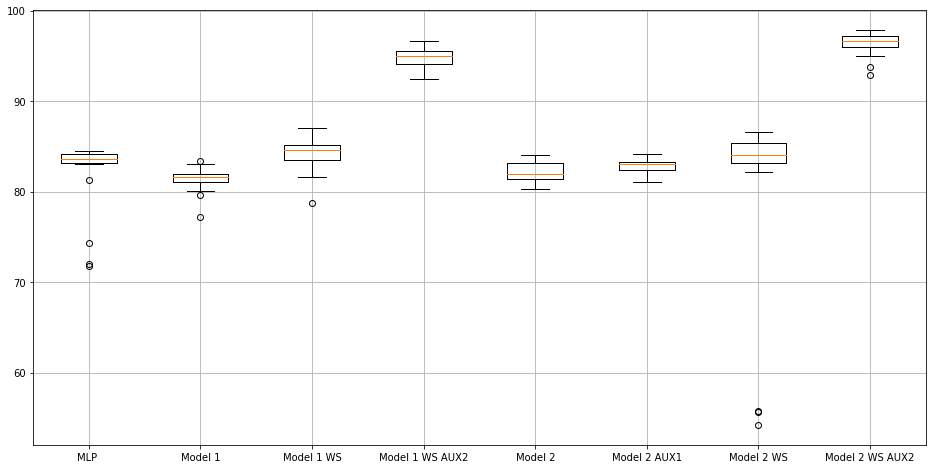

In [408]:
plt.figure(figsize=(16, 8))
plt.boxplot([x[0] for x in results], labels = [x[1][0] for x in results])
plt.grid(True)
plt.show()